In [2]:
import pickle
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score


In [3]:
#define pickle paths
model_pathLR = '../pickle/LogisticRegression/gptNeo_model.pkl'
model_pathRF = '../pickle/RandomForest/gptNeo_model.pkl'
model_pathSVM = '../pickle/LogisticRegression/gptNeo_model.pkl'

In [4]:
data = pd.read_csv('../../preprocessing/StorePreprocessed/GPTNeocsv.csv')
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42, stratify=data["label"])
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4), max_features=11000)
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [5]:
#load individual pickle-models
if os.path.exists(model_pathLR) and os.path.exists(model_pathRF) and os.path.exists(model_pathSVM):
    with open(model_pathLR, 'rb') as lr:
        lr_best = pickle.load(lr)
    with open(model_pathRF, 'rb') as rf:
        rf_best = pickle.load(rf)
    with open(model_pathSVM, 'rb') as svm:
        svm_best = pickle.load(svm)
else:
    print('Model not found')
    exit(1)

In [6]:
y_pred_svm = svm_best.predict(X_test)

y_pred_lr = lr_best.predict(X_test)

y_pred_rf = rf_best.predict(X_test)

In [7]:
#Mayority Voting
predictions = np.array([y_pred_rf, y_pred_lr, y_pred_svm])

y_pred_combined = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

print("Combined Model Classification Report:\n", classification_report(y_test, y_pred_combined))
print("Combined Model Accuracy:", accuracy_score(y_test, y_pred_combined))

Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      2000
           1       0.80      0.76      0.78      1975

    accuracy                           0.79      3975
   macro avg       0.79      0.79      0.79      3975
weighted avg       0.79      0.79      0.79      3975

Combined Model Accuracy: 0.7879245283018868


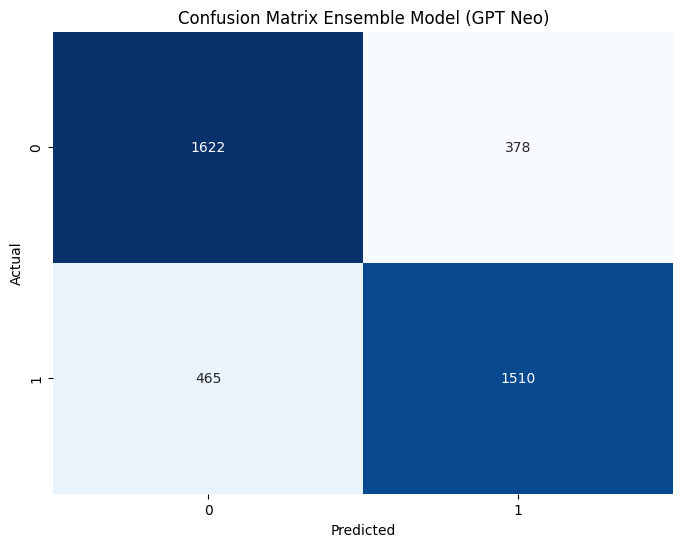

In [8]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred_combined)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Ensemble Model (GPT Neo)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../../evaluation/GPTNeo_Evaluation/Confusion_Matrix_Ensemble.png')
plt.show()

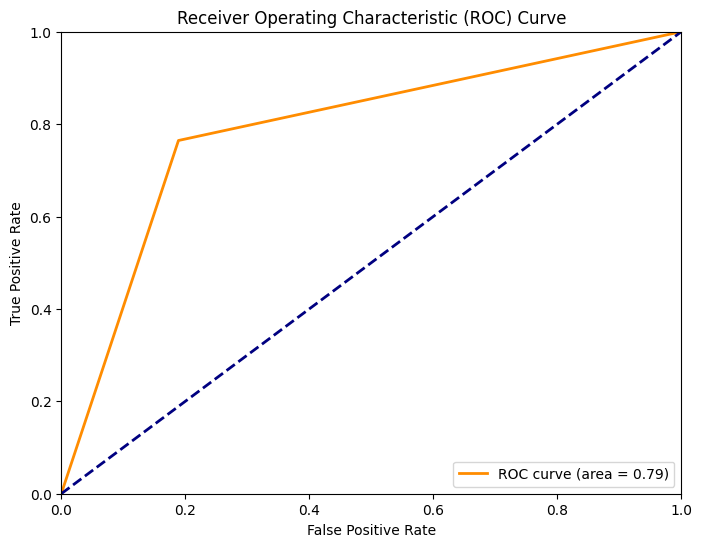

Combined Model AUC: 0.79


In [9]:
# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_combined)
roc_auc = roc_auc_score(y_test, y_pred_combined)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.savefig('../../evaluation/GPT35_Evaluation/ROC_Curve_Ensemble.png')
plt.show()

print(f"Combined Model AUC: {roc_auc:.2f}")